# Empirical data analysis

On this notebook we make some analysis so that we can find the best parameters for the creation of the empirical network. We need to find the minimum similarity parameter, that means, the minimum similarity so we can say that an article has influenced another, and the time difference parameter, where we define the maximum time distance between two similar articles.

## Importing some data

In [1]:
from bson import json_util, ObjectId

from gensim.models.word2vec import Word2Vec
from operator import itemgetter
from nltk.corpus import stopwords
from gensim import corpora, models
from string import punctuation
from urllib.parse import urlparse
import numpy as np
import nltk
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn
import math
%pylab inline

seaborn.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('../data/charliehebdo.json') as f:
    a = f.read()
    list_of_dict = json_util.loads(a)

# Fixing some data issues
del_pos = []
for pos,i in enumerate(list_of_dict):
    if 'published' not in i:
        i['published'] = i['updated']
    if i['published'].year < 2015:
        del_pos.append(i)

for i in del_pos:
    list_of_dict.remove(i)

# sort the list from the first published article to the last one.
# data[0].published < data[1].published
articles = sorted(list_of_dict, key=itemgetter('published'))
del articles[0]

In [39]:
import pandas as pd
df= pd.read_csv('../charlie_results/dists_triu.csv',sep=',',header=None)
dists_triu = df.values

In [40]:
df1= pd.read_csv('../charlie_results/list_ids.csv',sep=',',header=None)
list_ids = df1[0].values
list_ids=[ObjectId(i) for i in list_ids]

## Time matrix analysis

In [41]:
def consulta(id,data):
    for i in data:
        if i['_id'] == id:
            return i

def create_time_list(data,ids):
    lista = []
    for i in ids:
        article = consulta(i,data)
        if 'updated' in article:
             lista.append(article['updated'])
        else:
            lista.append(article['published'])
    return lista

#triangular matrix of time differences
# each x_ij, i_time - j_time  
def create_time_dif(time_list):
    times_dif = np.full(dists_triu.shape,300)
    for l,i in enumerate(time_list):
        c = l
        for k,j in enumerate(time_list[l:]):
            dif = i-j
            day_dif = abs(dif.total_seconds()/3600)/24.
            times_dif[l,c] = day_dif
            c+=1
    np.fill_diagonal(times_dif,0)
    return(times_dif)

In [42]:
time_list = create_time_list(articles,list_ids)
difs = create_time_dif(time_list)

/home/elisa/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full((2115, 2115), 300) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [43]:
df = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10])

for days in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    days_column = []
    
    for i in range(dists_triu.shape[0]-1):
        c = i+1
        
        dists_column = dists_triu[:,c]
        difs_column = difs[:,c]
 
        #articles that have time difference minor or equal that 'days'
        difs_ok = np.where(difs_column <= days)
        for i in difs_ok[0]:
            if difs_column[i] > days:
                print(days,i)
        if difs_ok[0].size != 0:
            dists_ok = [dists_column[i] for i in difs_ok[0]]
            dist = max(dists_ok)
            if dist < 0.8:
                ans = np.nan
            else:
                pos = dists_ok.index(dist)
                ans = difs_column[difs_ok[0][pos]]
                if ans > days:
                    print('i')
            
        else:
            ans = np.nan
        days_column.append(ans)

    df[days] = days_column
    

In [44]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898,0.630898
1,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300,0.737300
2,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562,0.025562
3,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145,0.006145
4,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420,0.742420


/home/elisa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


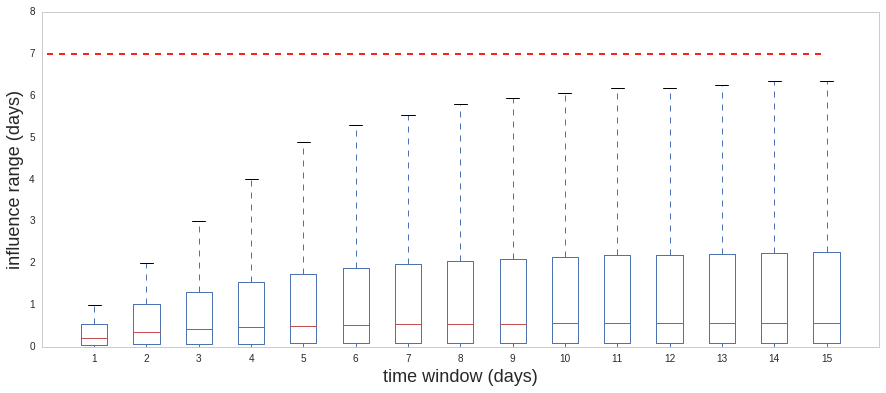

In [47]:
l1 = np.arange(-2,16)

plt.figure(figsize=(15, 6))

df.boxplot(whis=95/50)

plt.plot(list(l1), 18*[7], '--', c='r')
axis([0,16,0,8])
grid(False)
plt.xlabel('time window (days)',fontsize=18)
plt.ylabel('influence range (days)', fontsize=18)
savefig('../charlie_results/time_influence_range.png', dip=300)

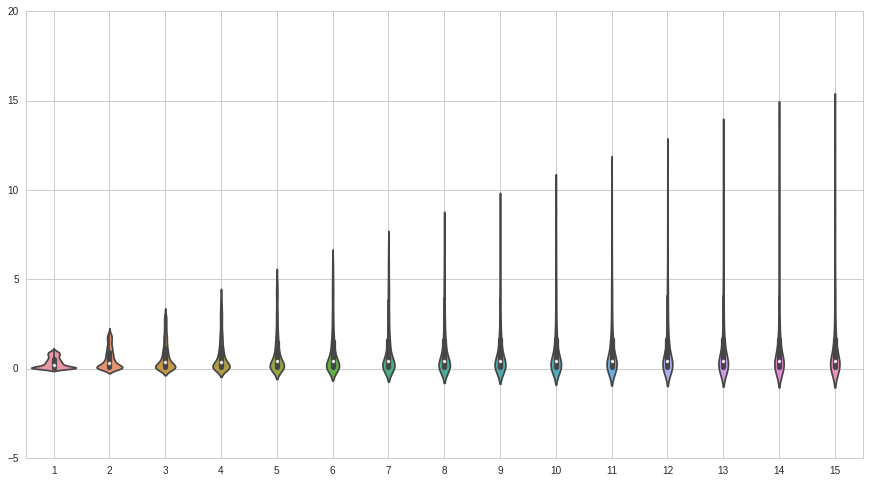

In [43]:
fig = figure(figsize=(15,8))
ax = gca()
seaborn.violinplot(data=df.dropna(), ax=ax)
grid(True)

## Similarity matrix analysis 

In [1]:
A = []
for i in dists_triu:
    for j in i:
        if j>0:
            A.append(j)
            
plt.hist(A, bins=20)
# plt.title('similarity distribution pairwise')
plt.savefig('../charlie_results/similarity_dist_pairwise.png', dpi=300)
plt.show()

NameError: name 'dists_triu' is not defined

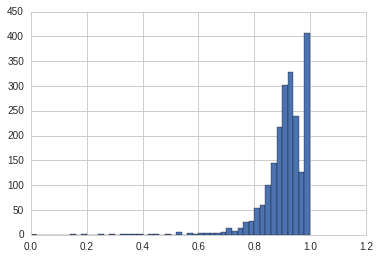

In [48]:
pairs = []
for i in dists_triu.T:
    pairs.append(max(i))
    
plt.hist(pairs,bins=50)
# plt.title('similarity distribution of the most similar for each article ')
plt.savefig('../charlie_results/similarity_dist_most_similar.png', dip=300)
# x é similarity
# y é number of pairs

In [12]:
def get_pos(data, pub_i, column_list, time_max, sim_min, outs):
    ans = False
    pos = None
    
    while ans == False:
        sim = max(column_list)
        pos = column_list.index(sim)
        time_dif = (pub_i - data[pos]['published']).total_seconds()/3600
        if sim < sim_min:
            pos = None
            ans = True
        elif pos in outs or time_dif > time_max:
            column_list[pos] = 0
        else:
            ans = True
    return pos

def create_graph_1(dists_triu, data, time_max=168, sim_min=0.8):
    size = dists_triu.shape[0]
    G = nx.Graph()
    G.add_node(0, step=0, date=data[0]['published'], domain=urlparse(data[0]['link']).netloc, _id=data[0]['_id'],
              children=[])
    outs = []
    for i in range(1,size):
        pub_i = data[i]['published']
        column = list(dists_triu[:,i])
        pos = get_pos(data, pub_i, column, time_max, sim_min, outs)

        if pos != None:
            if pos not in G.nodes():
                domain_1 = urlparse(data[pos]['link']).netloc
                G.add_node(pos, date=data[pos]['published'], domain=domain_1,
                           _id=data[pos]['_id'], children=[])
            if i not in G.nodes():
                domain_2 = urlparse(data[i]['link']).netloc
                G.add_node(i, date=pub_i, domain=domain_2, _id=data[i]['_id'], children=[])

            G.add_edge(pos, i)
        else:
            outs.append(i)
    return G

In [18]:
lista =[]
sims = np.arange(0.83,0.93,0.015)
for i in sims:
    G = create_graph_1(dists_triu,articles,sim_min=i)
    Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    G0=Gcc[0]       
    lista.append(G0.number_of_nodes()/dists_triu.shape[0])

In [16]:
lista2 = []
sims2 = np.arange(0.6,1,0.01)
for i in sims2:
    G = create_graph_1(dists_triu,articles,sim_min=i)
    Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    G0= Gcc[0]
    lista2.append(G0.number_of_nodes()/dists_triu.shape[0])

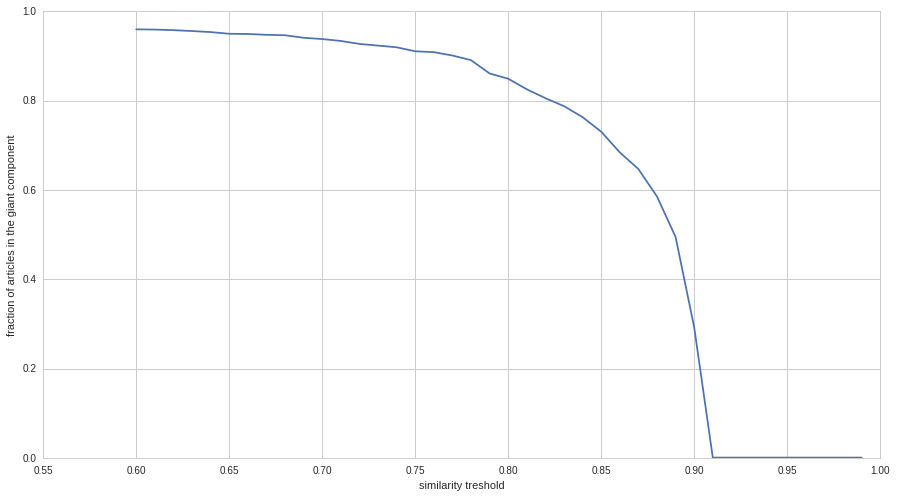

In [17]:
fig = figure(figsize=(15,8))
plt.plot(sims2, lista2)
plt.xlabel('similarity treshold')
plt.ylabel('fraction of articles in the giant component')


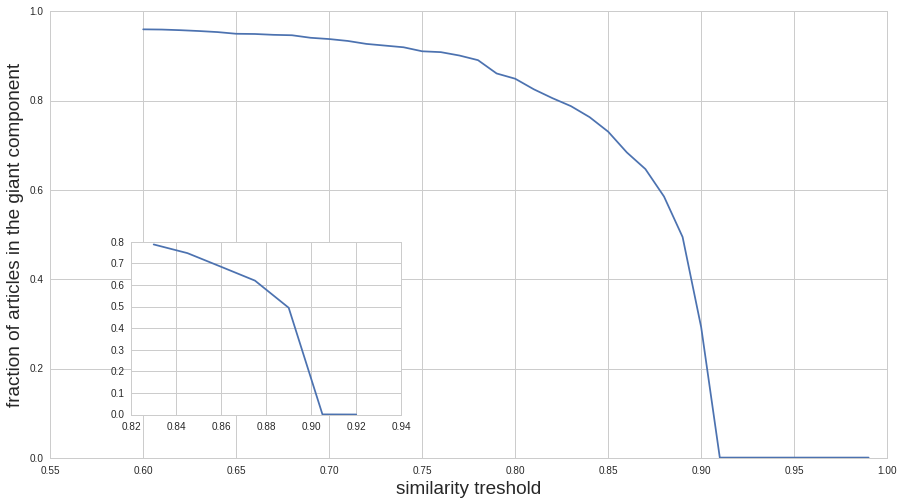

In [37]:
fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot(111)
ax1.plot(sims2, lista2)
plt.xlabel('similarity treshold', fontsize=19)
plt.ylabel('fraction of articles in the giant component', fontsize=19)
ax2 = plt.axes([.2, .2, .25, .3])
ax2.plot(sims,lista)
savefig('../charlie_results/similarity_treshold.png', dip=300)